In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
import pytorch_lightning as pl
import warnings
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.loggers.base import LightningLoggerBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import DataLoader
from typing import Optional, List, Dict, Any, Callable

warnings.filterwarnings("ignore")
pl.utilities.seed.seed_everything(42)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Global seed set to 42


In [2]:
def normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def standarize(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Load Data

In [3]:
class PimaIndiansDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data/diabetes.csv", train_batch_size: int = 64, val_batch_size: int = 64, transforms: List[Callable] = [], no_batch: bool = False):
        super().__init__()
        self.data_dir = data_dir
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.no_batch = no_batch
        self.transforms = transforms
        
    def prepare_data(self):
        self.full_data = pd.read_csv('data/diabetes.csv')
        self.full_data = self.full_data.drop(['Age'], axis=1)
        X = self.full_data.values[:, :-1]
        y = self.full_data.values[:, -1]
        for transform in self.transforms:
            X = transform(X)
        self.transformed_data = X
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        X_train = torch.tensor(X_train).float()
        X_test = torch.tensor(X_test).float()
        y_train = torch.tensor(y_train).long()
        y_test = torch.tensor(y_test).long()
        
        self.train_data = (X_train, y_train)
        self.test_data = (X_test, y_test)
    
    def setup(self, stage: Optional[str] = None):
        if stage == 'fit' or stage is None:
            X_train, y_train = self.train_data
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
            self.train_data = []
            self.val_data = []
            for x, y in zip(X_train, y_train):
                self.train_data.append((x, y))
                
            for x, y in zip(X_val, y_val):
                self.val_data.append((x, y))
            
            if self.no_batch:
                self.train_batch_size = len(self.train_data)
                self.val_batch_size = len(self.val_data)
        
        if stage == 'test' or stage is None:
            X_test, y_test = self.test_data
            self.test_data = []
            for x, y in zip(X_test, y_test):
                self.test_data.append((x, y))

    def train_dataloader(self):
        return DataLoader(self.train_data, self.train_batch_size, shuffle=True, num_workers=1, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, self.val_batch_size, shuffle=False, num_workers=1, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, shuffle=False, num_workers=1, pin_memory=True)

In [4]:
datamodule = PimaIndiansDataModule(no_batch=True, transforms=[normalize])
datamodule.prepare_data()

In [5]:
pca = PCA()
values = pca.fit_transform(datamodule.transformed_data)

7

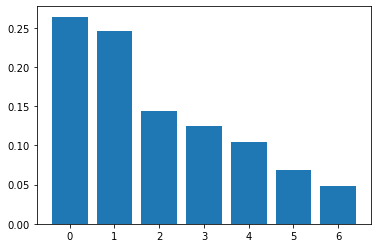

In [6]:
heights = pca.explained_variance_ratio_
gen = iter(range(0, 9, 1))
labels = [next(gen) for _ in heights]
plt.bar(labels, heights)
len(heights)

In [7]:
datamodule.full_data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
0,6,148,72,35,0,33.600,0.627,1
1,1,85,66,29,0,26.600,0.351,0
2,8,183,64,0,0,23.300,0.672,1
3,1,89,66,23,94,28.100,0.167,0
4,0,137,40,35,168,43.100,2.288,1


In [8]:
datamodule.full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


In [9]:
datamodule.full_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,1.000


In [10]:
one_class = sum(datamodule.full_data.values[:, -1])
zero_class = datamodule.full_data['Outcome'].size - one_class
print(f'Class 0: {zero_class}')
print(f'Class 1: {one_class}')

Class 0: 500.0
Class 1: 268.0


# Visualisation

In [11]:
def plot_hist(data, x, y, figsize=(13, 13), bins=15):
    fig, ax = plt.subplots(x, y, figsize=figsize)
    for i in range(data.transformed_data.shape[1]):
        ax[int(i / y), i % y].hist(data.transformed_data[:, i], bins=bins)
        ax[int(i / y), i % y].set_title(data.full_data.columns[i])
    plt.show()

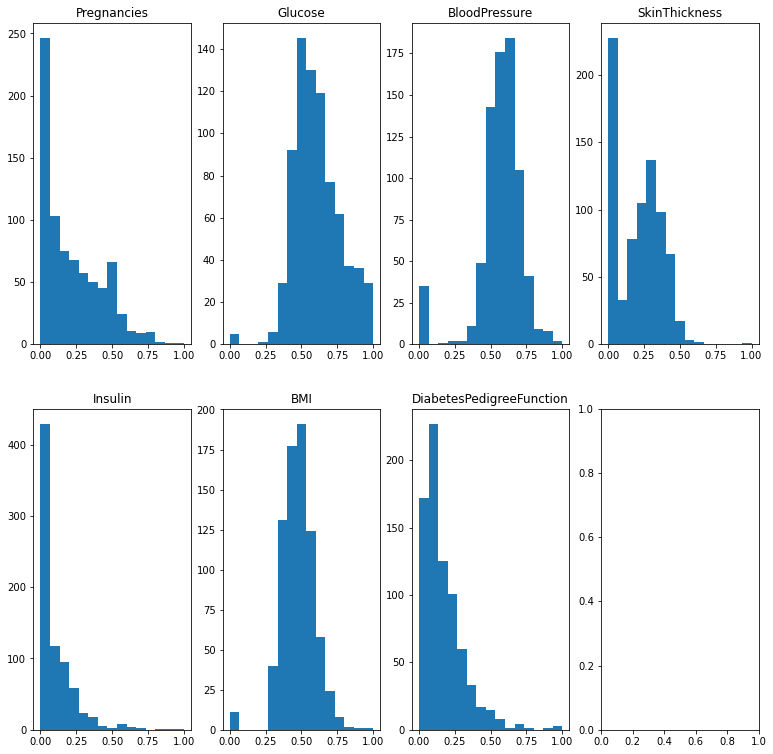

In [12]:
plot_hist(datamodule, 2, 4)

# Models

In [13]:
class Classifier(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr
    
    def forward(self, x):
        return self.model.forward(x)
        
    def shared_step(self, batch):
        x, y = batch
        pred = self(x)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(pred, y)
        return pred, loss
        
    def training_step(self, train_batch, batch_idx):
        pred, loss = self.shared_step(train_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = train_batch
        return {'loss': loss, 'train_score': (predicted, y)}
    
    def training_epoch_end(self, outputs):
        loss = [output['loss'] for output in outputs]
        loss_nd = np.double(loss[-1].detach().cpu().numpy())
        
        results = [x['train_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        f1 = f1_score(y, preds)
        self.log('loss', loss_nd, logger=True)
        self.log('train_f1', f1, prog_bar=True, logger=True)
    
    def validation_step(self, val_batch, val_batch_idx):
        pred, loss = self.shared_step(val_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = val_batch
        return {'val_loss': loss, 'val_score': (predicted, y)}
    
    def validation_epoch_end(self, outputs):
        results = [x['val_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        f1 = f1_score(y, preds)
        self.log('val_f1', f1, prog_bar=True, logger=True)
        
    def test_step(self, test_batch, test_batch_idx):
        pred, loss = self.shared_step(test_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = test_batch
        return {'test_loss': loss, 'test_score': (predicted, y)}
    
    def test_epoch_end(self, outputs):
        results = [x['test_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        acc = accuracy_score(y, preds)
        f1 = f1_score(y, preds)
        self.log('accuracy', acc, prog_bar=True, logger=True)
        self.log('f1', f1, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]

In [14]:
class SpreadNNNoPool(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size * 2),
            nn.BatchNorm1d(in_size * 2),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 2, in_size * 4),
            nn.BatchNorm1d(in_size * 4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 4, in_size * 2),
            nn.BatchNorm1d(in_size * 2),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 2, int(in_size / 2)),
            nn.BatchNorm1d(int(in_size / 2)),
            nn.LeakyReLU(),
            
            nn.Linear(int(in_size / 2), out_size)
        )
        
        self.name = 'spreadnn_no_pool.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [15]:
class SpreadNNNoPoolBig(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        in_size_2 = in_size * 2
        in_size_4 = in_size * 4
        in_size_8 = in_size * 8
        in_size_16 = in_size * 16
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_8),
            nn.BatchNorm1d(in_size_8),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_8, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size),
            nn.BatchNorm1d(in_size),
            nn.LeakyReLU(),
            
            nn.Linear(in_size, out_size)
        )
        
        self.name = 'spreadnn_no_pool_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [16]:
class SpreadNNNoPoolGigaBig(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(8, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            
            nn.Linear(8, 2)
        )
        
        self.name = 'spreadnn_no_pool_giga_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [17]:
class SpreadNNNoPoolDoubleBig(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        in_size_2 = in_size * 2
        in_size_4 = in_size * 4
        in_size_8 = in_size * 8
        in_size_16 = in_size * 16
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_8),
            nn.BatchNorm1d(in_size_8),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_8, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size),
            nn.BatchNorm1d(in_size),
            nn.LeakyReLU(),
            
            nn.Linear(in_size, out_size)
        )
        
        self.name = 'spreadnn_no_pool_double_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [18]:
class SpreadNNSmall(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(),
            
            nn.Linear(4, 2)
        )
        
        self.name = 'spreadnn_small.ckpt'
    
    def forward(self, x):
        return self._nn(x)

# Evaluation

In [19]:
def generate(elem, count, step):
    current = elem
    output = []
    for _ in range(count):
        output.append(current)
        current += step
    return output

In [20]:
class Evaluator:
    def __init__(self, models: List[pl.LightningModule], version: str, trainer_params: Dict[str, Any] = {}, logger: LightningLoggerBase = MLFlowLogger, logger_params: Dict[str, Any] = {},
                 callbacks=[], callback_params={}):
        self.models = models
        self.classifiers = [Classifier(model) for model in models]
        self.version = version
        self.paths = ['model/' + version + model.name for model in models]
        self.loggers = [logger(**logger_params) for _ in models]
        self.callbacks = []
        for _ in models:
            self.callbacks.append([callback(**callback_params) for callback in callbacks])
        self.trainer_params = trainer_params
    
    def train(self, min_lr: float, datamodule: pl.LightningDataModule, transforms: List[Callable], find_lr: bool = True, verbose: bool = False):
        for path, classifier, logger, callback in zip(self.paths, self.classifiers, self.loggers, self.callbacks):
            self.trainer = pl.Trainer(logger=logger, callbacks=callback, **self.trainer_params)
            if find_lr:
                lr_finder = self.trainer.tuner.lr_find(classifier, min_lr=min_lr, datamodule=datamodule(no_batch=True, transforms=transforms), early_stop_threshold=None)
                classifier.lr = lr_finder.suggestion()
            else:
                classifier.lr = min_lr

            if verbose and find_lr:
                print(f'Best lr: {classifier.lr}')

            self.trainer.fit(classifier, datamodule(no_batch=True, transforms=transforms))
            self.trainer.save_checkpoint(path)
    
    def test(self, datamodule: pl.LightningDataModule, transforms: List[Callable]):
        for path, model, logger in zip(self.paths, self.models, self.loggers):
            self.trainer = pl.Trainer(logger=logger, **self.trainer_params)
            classifier = Classifier.load_from_checkpoint(path, model=model)
            self.trainer.test(classifier, datamodule=datamodule(no_batch=True, transforms=transforms))

In [21]:
class LinearSearch:
    def __init__(self, grid_params, combinations):
        self.grid_params = grid_params
        self.combinations = combinations
    
    def search(self, models, in_size, out_size, datamodule, versions, min_lr, transforms, find_lr, verbose, callbacks=[], callback_params={}):
        for i in range(self.combinations):
            obj_models = [model(in_size, out_size) for model in models]
            params = {}
            for key in self.grid_params.keys():
                params[key] = self.grid_params[key][i]
            print(params)
            evaluator = Evaluator(obj_models, versions[i], params, callbacks=callbacks, callback_params=callback_params)
            evaluator.train(min_lr, datamodule, transforms, find_lr=find_lr, verbose=verbose)
            evaluator.test(datamodule, transforms)

In [22]:
models = [SpreadNNNoPoolBig, SpreadNNNoPoolDoubleBig]
min_lr = 1e-03
in_size = 7
out_size = 2
datamodule = PimaIndiansDataModule
transforms = [normalize]
early_stopping_params = {'monitor': 'loss', 'min_delta': 0.001, 'patience': 6}
callbacks = [EarlyStopping]
params_count = 6
params = {
    'gpus': generate(1, params_count, 0),
    'max_epochs': [20, 30, 40, 50, 75, 100],
    'gradient_clip_val': generate(0.5, params_count, 0.),
    'stochastic_weight_avg': generate(True, params_count, False),
    'amp_level': generate('O3', params_count, ''),
    'precision': generate(16, params_count, 0)
}
versions = [str(max_epoch) + 'epoch_' for max_epoch in params['max_epochs']]

In [23]:
linear_search = LinearSearch(params, params_count)
linear_search.search(models, in_size, out_size, datamodule, versions, min_lr, transforms, False, False, callbacks, early_stopping_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'gpus': 1, 'max_epochs': 20, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': True, 'amp_level': 'O3', 'precision': 16}



  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.20s/it, loss=0.725, v_num=3cca, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.702, v_num=3cca, val_f1=0.521, train_f1=0.445]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.685, v_num=3cca, val_f1=0.521, train_f1=0.518]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.672, v_num=3cca, val_f1=0.521, train_f1=0.576]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.662, v_num=3cca, val_f1=0.521, train_f1=0.619]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.653, v_num=3cca, val_f1=0.552, train_f1=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.646, v_num=3cca, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DB4186A0> for <torch.optim.swa_utils.SWALR object at 0x00000274A10802B0>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.605, v_num=3cca, val_f1=0.000, train_f1=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.603, v_num=3cca, val_f1=0.000, train_f1=0.714]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|███████████           | 1/2 [00:02<00:02,  2.10s/it, loss=0.6, v_num=3cca, val_f1=0.000, train_f1=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.597, v_num=3cca, val_f1=0.000, train_f1=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.595, v_num=3cca, val_f1=0.000, train_f1=0.715]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.12s/it, loss=0.595, v_num=3cca, val_f1=0.000, train_f1=0.713]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:02<00:00,  1.07it/s, loss=0.595, v_num=3cca, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.19s/it, loss=0.667, v_num=049f, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.624, v_num=049f, val_f1=0.000, train_f1=0.490]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.594, v_num=049f, val_f1=0.000, train_f1=0.618]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.571, v_num=049f, val_f1=0.000, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.553, v_num=049f, val_f1=0.000, train_f1=0.721]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.538, v_num=049f, val_f1=0.000, train_f1=0.746]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.525, v_num=049f, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274A108AFA0> for <torch.optim.swa_utils.SWALR object at 0x00000274A108A7C0>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.451, v_num=049f, val_f1=0.000, train_f1=0.884]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.446, v_num=049f, val_f1=0.000, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.441, v_num=049f, val_f1=0.000, train_f1=0.893]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.435, v_num=049f, val_f1=0.000, train_f1=0.901]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.431, v_num=049f, val_f1=0.000, train_f1=0.904]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.07s/it, loss=0.431, v_num=049f, val_f1=0.000, train_f1=0.908]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.38s/it, loss=0.431, v_num=049f, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.85it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7748917748917749, 'f1': 0.6790123456790124}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.74it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8744588744588745, 'f1': 0.8104575163398693}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 30, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.691, v_num=2214, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.11s/it, loss=0.67, v_num=2214, val_f1=0.521, train_f1=0.339]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.655, v_num=2214, val_f1=0.521, train_f1=0.485]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.643, v_num=2214, val_f1=0.521, train_f1=0.605]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.20s/it, loss=0.633, v_num=2214, val_f1=0.521, train_f1=0.647]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.625, v_num=2214, val_f1=0.521, train_f1=0.682]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.619, v_num=2214, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274A107BCA0> for <torch.optim.swa_utils.SWALR object at 0x00000274A1052AC0>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.553, v_num=2214, val_f1=0.600, train_f1=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.55, v_num=2214, val_f1=0.595, train_f1=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████          | 1/2 [00:02<00:02,  2.19s/it, loss=0.547, v_num=2214, val_f1=0.595, train_f1=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.20s/it, loss=0.544, v_num=2214, val_f1=0.595, train_f1=0.801]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.541, v_num=2214, val_f1=0.595, train_f1=0.803]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.539, v_num=2214, val_f1=0.632, train_f1=0.803]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.537, v_num=2214, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.07s/it, loss=0.93, v_num=5d18, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.877, v_num=5d18, val_f1=0.521, train_f1=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.842, v_num=5d18, val_f1=0.521, train_f1=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.818, v_num=5d18, val_f1=0.521, train_f1=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.799, v_num=5d18, val_f1=0.521, train_f1=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.782, v_num=5d18, val_f1=0.521, train_f1=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.768, v_num=5d18, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DB024550> for <torch.optim.swa_utils.SWALR object at 0x00000274DB033AC0>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.624, v_num=5d18, val_f1=0.521, train_f1=0.614]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.616, v_num=5d18, val_f1=0.521, train_f1=0.617]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.61, v_num=5d18, val_f1=0.521, train_f1=0.619]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.604, v_num=5d18, val_f1=0.521, train_f1=0.622]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.598, v_num=5d18, val_f1=0.521, train_f1=0.623]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.593, v_num=5d18, val_f1=0.521, train_f1=0.622]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.589, v_num=5d18, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.80it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8008658008658008, 'f1': 0.7500000000000001}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.03it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.6103896103896104, 'f1': 0.64}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 40, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.11s/it, loss=0.693, v_num=2e60, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.672, v_num=2e60, val_f1=0.000, train_f1=0.373]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.655, v_num=2e60, val_f1=0.000, train_f1=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.642, v_num=2e60, val_f1=0.000, train_f1=0.613]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|███████████           | 1/2 [00:02<00:02,  2.12s/it, loss=0.63, v_num=2e60, val_f1=0.000, train_f1=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████           | 1/2 [00:02<00:02,  2.14s/it, loss=0.62, v_num=2e60, val_f1=0.000, train_f1=0.668]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.612, v_num=2e60, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DAF30D60> for <torch.optim.swa_utils.SWALR object at 0x00000274D9C8B0D0>


Epoch 31:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.49, v_num=2e60, val_f1=0.483, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.487, v_num=2e60, val_f1=0.483, train_f1=0.821]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.485, v_num=2e60, val_f1=0.581, train_f1=0.824]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.482, v_num=2e60, val_f1=0.581, train_f1=0.824]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.48, v_num=2e60, val_f1=0.581, train_f1=0.829]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.478, v_num=2e60, val_f1=0.545, train_f1=0.831]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.476, v_num=2e60, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.10s/it, loss=0.656, v_num=6846, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.614, v_num=6846, val_f1=0.000, train_f1=0.0234]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.589, v_num=6846, val_f1=0.000, train_f1=0.0575]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.571, v_num=6846, val_f1=0.000, train_f1=0.132]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.557, v_num=6846, val_f1=0.000, train_f1=0.182]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.546, v_num=6846, val_f1=0.000, train_f1=0.238]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.537, v_num=6846, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274A1062430> for <torch.optim.swa_utils.SWALR object at 0x00000274D9CCDF10>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.417, v_num=6846, val_f1=0.000, train_f1=0.629]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.415, v_num=6846, val_f1=0.000, train_f1=0.634]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.413, v_num=6846, val_f1=0.000, train_f1=0.634]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.411, v_num=6846, val_f1=0.000, train_f1=0.645]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.409, v_num=6846, val_f1=0.000, train_f1=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.407, v_num=6846, val_f1=0.190, train_f1=0.661]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.405, v_num=6846, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.43it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8398268398268398, 'f1': 0.7885714285714285}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 89.81it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7489177489177489, 'f1': 0.4528301886792453}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 50, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.09s/it, loss=0.735, v_num=e4d9, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.16s/it, loss=0.72, v_num=e4d9, val_f1=0.521, train_f1=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.708, v_num=e4d9, val_f1=0.521, train_f1=0.526]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.698, v_num=e4d9, val_f1=0.521, train_f1=0.560]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|███████████           | 1/2 [00:02<00:02,  2.12s/it, loss=0.69, v_num=e4d9, val_f1=0.521, train_f1=0.589]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.24s/it, loss=0.683, v_num=e4d9, val_f1=0.521, train_f1=0.606]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.677, v_num=e4d9, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274A10AB100> for <torch.optim.swa_utils.SWALR object at 0x00000274A109AFA0>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.568, v_num=e4d9, val_f1=0.588, train_f1=0.721]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.567, v_num=e4d9, val_f1=0.588, train_f1=0.722]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.21s/it, loss=0.565, v_num=e4d9, val_f1=0.600, train_f1=0.724]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.564, v_num=e4d9, val_f1=0.600, train_f1=0.724]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.563, v_num=e4d9, val_f1=0.588, train_f1=0.726]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.562, v_num=e4d9, val_f1=0.588, train_f1=0.727]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.561, v_num=e4d9, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.10s/it, loss=0.68, v_num=d948, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.15s/it, loss=0.64, v_num=d948, val_f1=0.000, train_f1=0.352]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.616, v_num=d948, val_f1=0.000, train_f1=0.552]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.599, v_num=d948, val_f1=0.000, train_f1=0.648]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.586, v_num=d948, val_f1=0.000, train_f1=0.676]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.575, v_num=d948, val_f1=0.000, train_f1=0.711]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.566, v_num=d948, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DAEC1730> for <torch.optim.swa_utils.SWALR object at 0x00000274A1096250>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.415, v_num=d948, val_f1=0.581, train_f1=0.910]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.413, v_num=d948, val_f1=0.581, train_f1=0.913]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.411, v_num=d948, val_f1=0.581, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.41, v_num=d948, val_f1=0.581, train_f1=0.920]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.408, v_num=d948, val_f1=0.581, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.406, v_num=d948, val_f1=0.581, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.405, v_num=d948, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.56it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7316017316017316, 'f1': 0.6900000000000001}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.71it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8874458874458875, 'f1': 0.8194444444444445}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 75, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.15s/it, loss=0.739, v_num=47cb, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.709, v_num=47cb, val_f1=0.000, train_f1=0.195]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.684, v_num=47cb, val_f1=0.000, train_f1=0.278]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.664, v_num=47cb, val_f1=0.000, train_f1=0.403]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.647, v_num=47cb, val_f1=0.000, train_f1=0.489]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.633, v_num=47cb, val_f1=0.000, train_f1=0.539]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.621, v_num=47cb, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DB077730> for <torch.optim.swa_utils.SWALR object at 0x00000274DB092370>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.437, v_num=47cb, val_f1=0.375, train_f1=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.436, v_num=47cb, val_f1=0.375, train_f1=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.436, v_num=47cb, val_f1=0.375, train_f1=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.435, v_num=47cb, val_f1=0.364, train_f1=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.435, v_num=47cb, val_f1=0.364, train_f1=0.795]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.434, v_num=47cb, val_f1=0.364, train_f1=0.795]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.434, v_num=47cb, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.11s/it, loss=0.714, v_num=4eb0, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.673, v_num=4eb0, val_f1=0.521, train_f1=0.402]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.647, v_num=4eb0, val_f1=0.521, train_f1=0.547]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.628, v_num=4eb0, val_f1=0.521, train_f1=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.613, v_num=4eb0, val_f1=0.521, train_f1=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.602, v_num=4eb0, val_f1=0.521, train_f1=0.731]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.593, v_num=4eb0, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274A10493D0> for <torch.optim.swa_utils.SWALR object at 0x00000274DAD0B0D0>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.449, v_num=4eb0, val_f1=0.649, train_f1=0.933]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.449, v_num=4eb0, val_f1=0.632, train_f1=0.933]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.448, v_num=4eb0, val_f1=0.632, train_f1=0.933]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.448, v_num=4eb0, val_f1=0.632, train_f1=0.933]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.448, v_num=4eb0, val_f1=0.615, train_f1=0.933]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.447, v_num=4eb0, val_f1=0.615, train_f1=0.936]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.447, v_num=4eb0, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.60it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8268398268398268, 'f1': 0.7297297297297297}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.98it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 12.1 K
--------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8528138528138528, 'f1': 0.7901234567901234}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 100, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.10s/it, loss=0.746, v_num=1b94, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.06s/it, loss=0.73, v_num=1b94, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.718, v_num=1b94, val_f1=0.521, train_f1=0.540]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.709, v_num=1b94, val_f1=0.521, train_f1=0.550]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.701, v_num=1b94, val_f1=0.521, train_f1=0.564]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.694, v_num=1b94, val_f1=0.521, train_f1=0.578]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.689, v_num=1b94, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 25.0 K
--------------------------------------------------
25.0 K    Trainable params
0         Non-trainable params
25.0 K    Total params
0.100     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.07s/it, loss=0.649, v_num=92d1, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.616, v_num=92d1, val_f1=0.000, train_f1=0.386]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.593, v_num=92d1, val_f1=0.000, train_f1=0.514]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.577, v_num=92d1, val_f1=0.000, train_f1=0.596]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.564, v_num=92d1, val_f1=0.000, train_f1=0.637]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.554, v_num=92d1, val_f1=0.000, train_f1=0.662]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.545, v_num=92d1, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000274DAD033D0> for <torch.optim.swa_utils.SWALR object at 0x00000274DB08D8E0>


Epoch 79:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.376, v_num=92d1, val_f1=0.750, train_f1=0.928]
Validating: 0it [00:00, ?it/s]
Epoch 80:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.376, v_num=92d1, val_f1=0.750, train_f1=0.928]
Validating: 0it [00:00, ?it/s]
Epoch 81:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.376, v_num=92d1, val_f1=0.750, train_f1=0.928]
Validating: 0it [00:00, ?it/s]
Epoch 82:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.376, v_num=92d1, val_f1=0.750, train_f1=0.931]
Validating: 0it [00:00, ?it/s]
Epoch 82: 100%|████████████████████| 2/2 [00:04<00:00,  2.14s/it, loss=0.376, v_num=92d1, val_f1=0.750, train_f1=0.931]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.13it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7056277056277056, 'f1': 0.6936936936936937}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.76it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8961038961038961, 'f1': 0.8378378378378379}
--------------------------------------------------------------------------------


In [ ]:
#Sprawdzić PCA bez pregnancy oraz output